In [1]:
# Pull data command:
# python download_data.py --project=discrete-mbrl-minigrid-baseline --history_vars n_step random_state_distrib_kl_div_mean goal_state_distrib_kl_div_mean explore_right_state_distrib_kl_div_mean --params codebook_size filter_size eval_policy env_name ae_model_type latent_dim trans_hidden

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [8]:
data_path = 'data/discrete-mbrl-minigrid-baseline_data.csv'
df = pd.read_csv(data_path, index_col=0)
df.head()

,step,n_step,ae_model_type,codebook_size,env_name,filter_size,latent_dim,trans_hidden,experiment_key,random_state_distrib_kl_div_mean,explore_right_state_distrib_kl_div_mean,goal_state_distrib_kl_div_mean
0,15,15,vqvae,1024,MiniGrid-Empty-6x6-v0-fullobs,9,None,64,f08aebddf9784921936d6598076360cc,NaN,NaN,NaN
1,16,16,vqvae,1024,MiniGrid-Empty-6x6-v0-fullobs,9,None,64,f08aebddf9784921936d6598076360cc,NaN,NaN,NaN
2,17,17,vqvae,1024,MiniGrid-Empty-6x6-v0-fullobs,9,None,64,f08aebddf9784921936d6598076360cc,NaN,NaN,NaN
3,18,18,vqvae,1024,MiniGrid-Empty-6x6-v0-fullobs,9,None,64,f08aebddf9784921936d6598076360cc,NaN,NaN,NaN
4,19,19,vqvae,1024,MiniGrid-Empty-6x6-v0-fullobs,9,None,64,f08aebddf9784921936d6598076360cc,NaN,NaN,NaN


In [9]:
kl_div_columns = [col for col in df.columns if 'kl_div' in col]
# Drop the rows where all of the columns are NaN
df = df.dropna(subset=kl_div_columns, how='all')

In [10]:
# Work out the policy types and simplify the KL divergence columns

def infer_policy_type(row):
  for key, val in row.items():
    if 'kl_div' in key and val is not None and not np.isnan(val):
      return key[:key.find('state')-1]
    

df['policy_type'] = df.apply(infer_policy_type, axis=1)
# df['state_distrib_kl_div'] = df.apply(
#   lambda row: row[row['policy_type'] + '_state_distrib_kl_div'],
#   axis=1)
df['state_distrib_kl_div_mean'] = df.apply(
  lambda row: row[row['policy_type'] + '_state_distrib_kl_div_mean'],
  axis=1)

df.drop(columns=kl_div_columns, inplace=True)

In [13]:
df['latent_dim'] = df.apply(
  lambda row: f'({row["filter_size"]**2} x {row["codebook_size"]})' \
  if row['ae_model_type'] == 'vqvae' else row['latent_dim'], axis=1)

MiniGrid-Empty-6x6-v0-fullobs | ae | random | 64
Latent dim: 1024, KL div mean: 0.028, n_runs: 4
Latent dim: 16, KL div mean: 0.028, n_runs: 4
Latent dim: 256, KL div mean: 0.065, n_runs: 4
Latent dim: 64, KL div mean: 0.026, n_runs: 3
Best params: 64 with KL div mean: 0.026
MiniGrid-Empty-6x6-v0-fullobs | vqvae | random | 64
Latent dim: (36 x 1024), KL div mean: 0.024, n_runs: 4
Latent dim: (36 x 16), KL div mean: 0.025, n_runs: 4
Latent dim: (36 x 256), KL div mean: 0.027, n_runs: 4
Latent dim: (36 x 64), KL div mean: 0.023, n_runs: 4
Latent dim: (81 x 1024), KL div mean: 0.025, n_runs: 3
Latent dim: (81 x 16), KL div mean: 0.032, n_runs: 4
Latent dim: (81 x 256), KL div mean: 0.027, n_runs: 4
Latent dim: (81 x 64), KL div mean: 0.028, n_runs: 4
Latent dim: (9 x 1024), KL div mean: 0.026, n_runs: 4
Latent dim: (9 x 16), KL div mean: 0.027, n_runs: 4
Latent dim: (9 x 256), KL div mean: 0.026, n_runs: 4
Latent dim: (9 x 64), KL div mean: 0.027, n_runs: 4
Best params: (36 x 64) with KL 

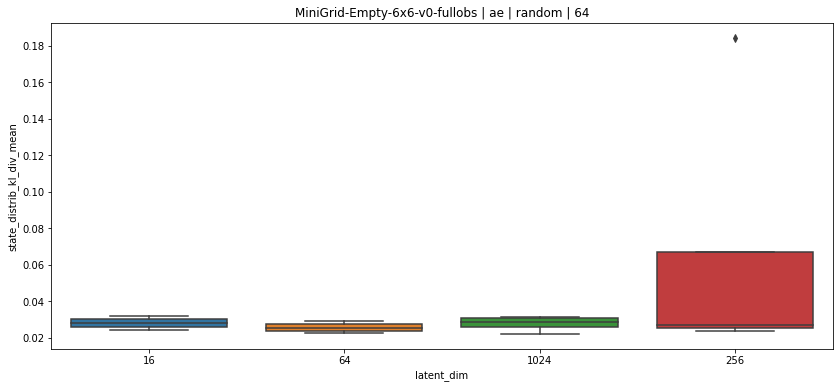

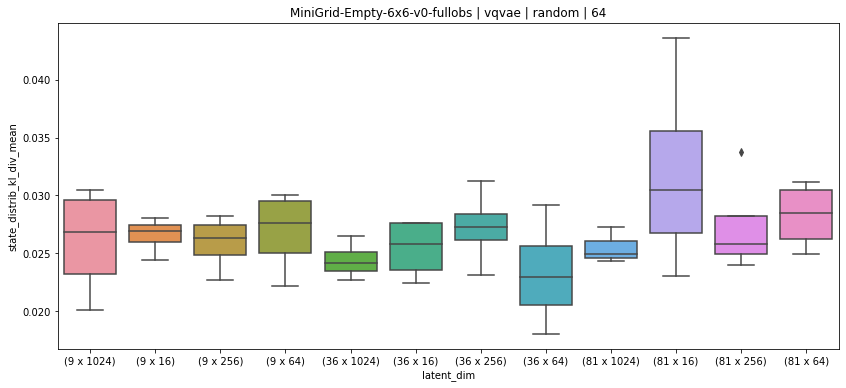

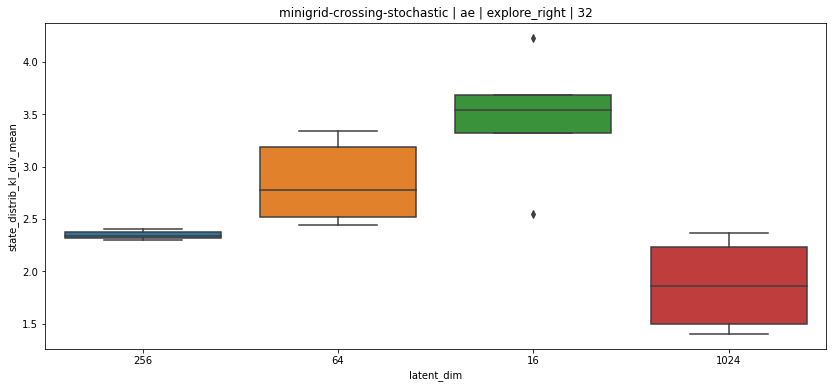

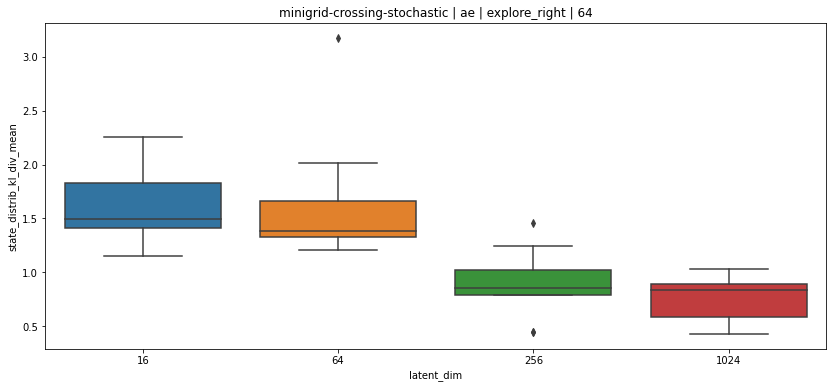

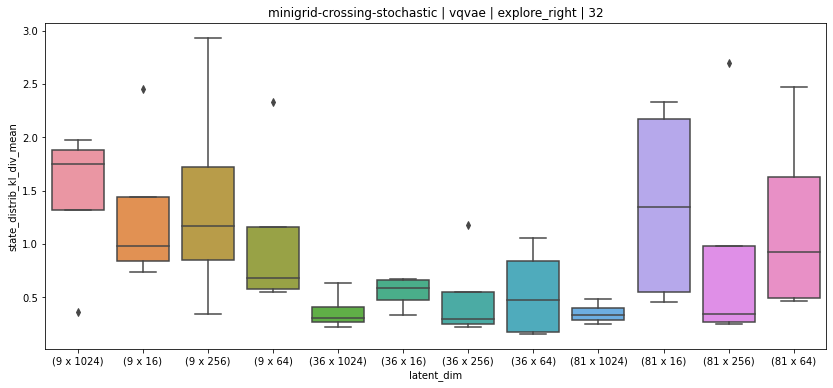

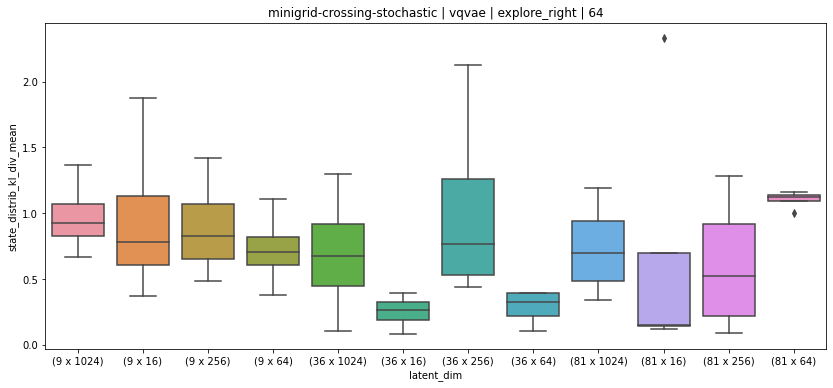

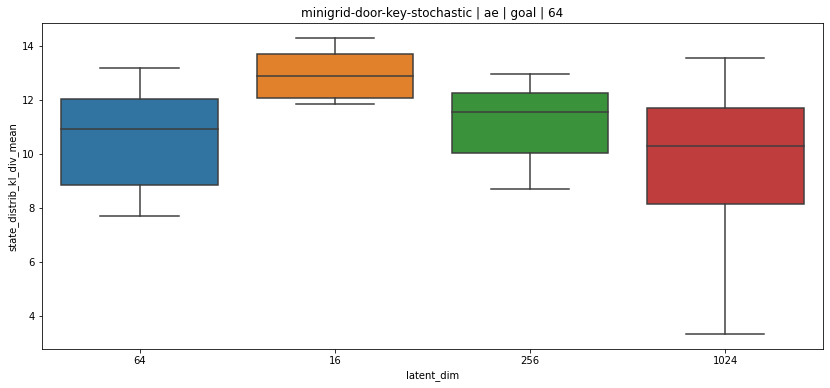

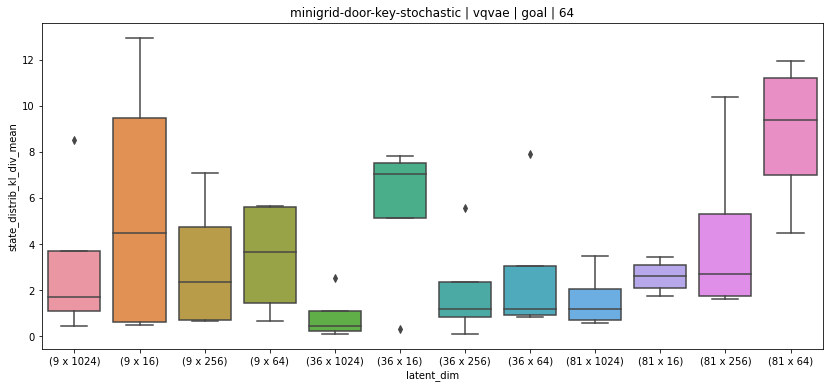

In [18]:
# tdf = df[(df['env_name'] == 'minigrid-crossing-stochastic') & \
#          (df['ae_model_type'] == 'hard_fta_ae')]
for keys, group in df.groupby(['env_name', 'ae_model_type', 'policy_type', 'trans_hidden']):
  # Sort df first by filter size, then by codebook size
  group = group.sort_values(by=['filter_size', 'codebook_size'])
  plt.figure(figsize=(14, 6))
  plt.title(' | '.join([str(k) for k in keys]))
  sns.boxplot(group, x='latent_dim', y='state_distrib_kl_div_mean')

  # Avg of kl_div_mean for each latent dim and report lowest value + num of runs
  print(' | '.join([str(k) for k in keys]))
  lowest_kl_div_mean = np.inf
  best_latent_dim = None
  for latent_dim, group in group.groupby('latent_dim'):
    kl_div_mean = group['state_distrib_kl_div_mean'].mean()
    n_runs = len(group)
    print(f'Latent dim: {latent_dim}, KL div mean: {kl_div_mean:.3f}, n_runs: {n_runs}')

    if kl_div_mean < lowest_kl_div_mean:
      lowest_kl_div_mean = kl_div_mean
      best_latent_dim = latent_dim
  # Report min with latent dim
  print(f'Best params: {best_latent_dim} with KL div mean: {lowest_kl_div_mean:.3f}')